## Load the preprocessed DataFrames generated in the preprocessing Notebook

In [1]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [2]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array
    """
    loaded_df = pd.read_csv(file_path)
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [3]:
train_df = load_luderick_df('luderick_train_preprocessed.csv')
val_df = load_luderick_df('luderick_val_preprocessed.csv')
test_df = load_luderick_df('luderick_test_preprocessed.csv')

train_df

,image_name,video_name,frame_number,number_boxes,labels,bounding_boxes,area,segmentation
0,04C1_Luderick_1.mov_5fps_000001.jpg,04C1_Luderick_1,1,1,[1],"[[1778, 425, 1919, 610]]",[26085],"[[1778, 515, 1789, 498, 1806, 479, 1835, 457, ..."
1,04C1_Luderick_1.mov_5fps_000002.jpg,04C1_Luderick_1,2,1,[1],"[[1659, 406, 1919, 645]]",[62140],"[[1659, 509, 1675, 488, 1696, 465, 1720, 437, ..."
2,04C1_Luderick_1.mov_5fps_000003.jpg,04C1_Luderick_1,3,1,[1],"[[1578, 400, 1915, 620]]",[74140],"[[1578, 530, 1585, 512, 1594, 496, 1592, 477, ..."
3,04C1_Luderick_1.mov_5fps_000004.jpg,04C1_Luderick_1,4,1,[1],"[[1508, 398, 1812, 626]]",[69312],"[[1812, 624, 1795, 578, 1795, 542, 1797, 507, ..."
4,04C1_Luderick_1.mov_5fps_000005.jpg,04C1_Luderick_1,5,1,[1],"[[1465, 390, 1699, 626]]",[55224],"[[1691, 591, 1687, 544, 1688, 503, 1691, 473, ..."
...,...,...,...,...,...,...,...,...
2667,C4_Luderick_9_014000.jpg,C4_Luderick_9,21,1,[1],"[[471, 127, 699, 360]]",[53124],"[[471, 360, 491, 319, 492, 280, 487, 236, 489,..."
2668,C4_Luderick_9_014200.jpg,C4_Luderick_9,22,1,[1],"[[561, 79, 829, 313]]",[62712],"[[578, 313, 592, 247, 618, 252, 656, 230, 679,..."
2669,C4_Luderick_9_014400.jpg,C4_Luderick_9,23,1,[1],"[[573, 33, 971, 261]]",[90744],"[[578, 261, 594, 213, 601, 183, 594, 146, 581,..."
2670,C4_Luderick_9_014600.jpg,C4_Luderick_9,24,1,[1],"[[650, 3, 1126, 216]]",[101388],"[[650, 216, 676, 182, 673, 133, 674, 90, 673, ..."


## Constants

In [4]:
sep = os.sep
DATASET_DIR = f".{sep}datasets{sep}luderick"  # dataset root dir
IMAGES_DIR = os.path.join("Fish_automated_identification_and_counting", "luderick-seagrass")

# classes: 0 index is reserved for background
CLASSES = ['Luderick']
NUM_CLASSES = len(CLASSES)


## Prepare the Dataset in the YOLO format

YOLO wants the following folder structure in the same folder of the yolov5 repository:


In [5]:
# datasets
#  │
#  └─ luderick
#     ├─ images
#     │   ├── train
#     │   │   ├── IMG_1.jpg
#     │   │   ...
#     │   │   └── IMG_X.jpg
#     │   │   
#     │   └── val
#     │       ├── IMG_1.jpg
#     │       ...
#     │       └── IMG_X.jpg
#     │  
#     │
#     └── labels
#         ├── train
#         │   ├── IMG_1.txt
#         │   ...
#         │   └── IMG_X.txt
#         │   
#         └── val
#             ├── IMG_1.txt
#             ...
#             └── IMG_X.txt

Annotation (labels) should have the following format:

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

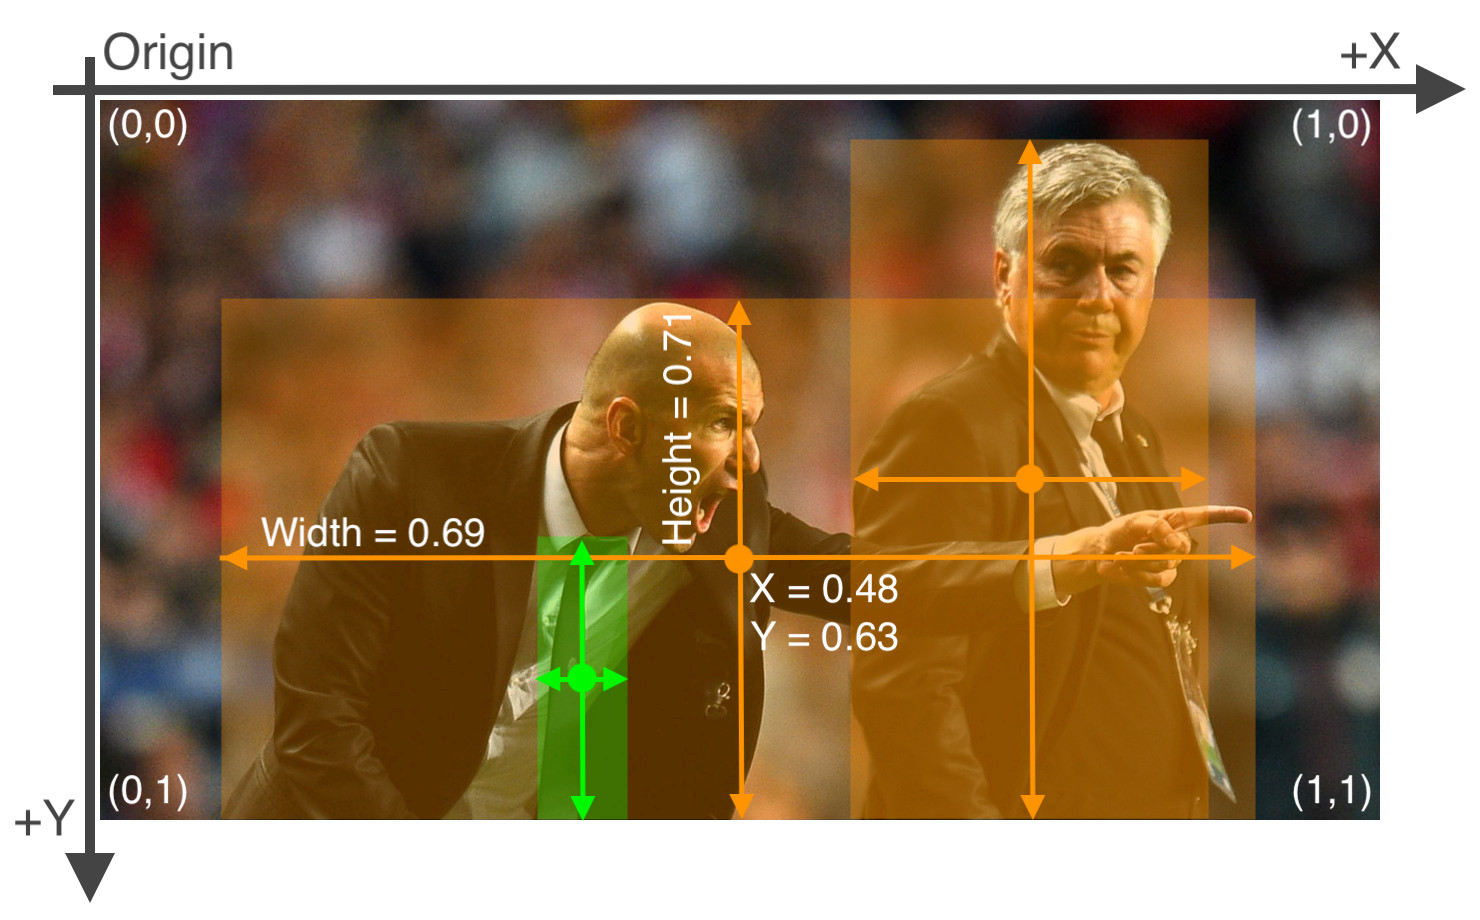

The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):

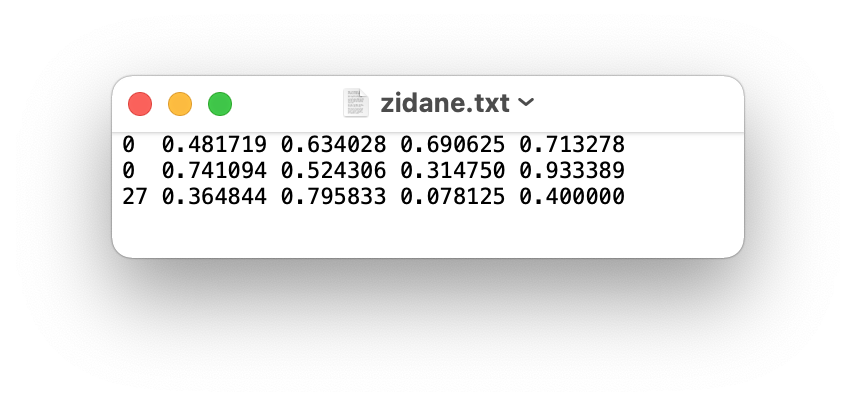

In [6]:
# Create folders

!mkdir datasets
%cd datasets
!mkdir luderick
%cd luderick
!mkdir images
!mkdir labels
%cd images
!mkdir train
!mkdir val
!mkdir test
%cd ../labels
!mkdir train
!mkdir val
!mkdir test
%cd ../../..

/home/ubuntu/luderick-seagrass/datasets
/home/ubuntu/luderick-seagrass/datasets/luderick
/home/ubuntu/luderick-seagrass/datasets/luderick/images
/home/ubuntu/luderick-seagrass/datasets/luderick/labels
/home/ubuntu/luderick-seagrass


In [7]:
# Copy images and create .txt annotations
def convert_to_yolo_dataset(luderick_df, images_dir, split_name):
    """
    Creates the yolo formatted labels from the luderick dataframe into datasets/luderick/labels/split_name
    and copies the images itno datasets/luderick/images/split_name
    """
    print("Starting dataset conversion...")
    sep = os.sep
    labels_out_path = f"datasets{sep}luderick{sep}labels{sep}{split_name}"
    img_out_path = f"datasets{sep}luderick{sep}images{sep}{split_name}"
    
    for _, row in tqdm(luderick_df.iterrows(), total= len(luderick_df)):
        image_path = os.path.join(images_dir, row['image_name'])
        image = Image.open(image_path).convert("RGB")
        # copy original image into yolo dataset path
        !cp {image_path} {img_out_path}
        
        width, height = image.size
        boxes = np.array(row['bounding_boxes'])
        labels = row['labels']
        image_name = row['image_name']
        # initialize the file
        # delete the .jpg from the image name
        label_file = open(f"{labels_out_path}{sep}{image_name[:-4]}.txt", 'a')
        for i, box in enumerate(boxes): 
            # get width and height
            box_width = box[2] - box[0]
            box_height = box[3] - box[1]
            # get the box center
            x_center = box[0] + (box_width / 2)
            y_center = box[1] + (box_height / 2)
            # normalize by dividing by image width and height
            x_center /= width
            box_width /= width
            y_center /= height
            box_height /= height
            # yolo class labels start from 0 and does not include the background
            class_label = labels[i] - 1 
            # create the yolo box line
            yolo_box = f"{class_label} {x_center} {y_center} {box_width} {box_height}"
            # add yolo box to a new line in the label file
            label_file.write(f'{yolo_box}\n')

        label_file.close()

In [8]:
# convert each dataset split
convert_to_yolo_dataset(train_df, IMAGES_DIR, 'train')

Starting dataset conversion...


100%|██████████| 2672/2672 [08:17<00:00,  5.37it/s]


In [9]:
convert_to_yolo_dataset(val_df, IMAGES_DIR, 'val')

Starting dataset conversion...


100%|██████████| 824/824 [02:29<00:00,  5.52it/s]


In [10]:
convert_to_yolo_dataset(test_df, IMAGES_DIR, 'test')

Starting dataset conversion...


100%|██████████| 761/761 [02:13<00:00,  5.70it/s]


In [11]:
# visualize one annotation
with open("datasets/luderick/labels/train/04C1_Luderick_1.mov_5fps_000009.txt") as file:
    lines = file.readlines()
    print(lines)

['0 0.9377604166666667 0.49583333333333335 0.12135416666666667 0.25462962962962965\n', '0 0.7010416666666667 0.4930555555555556 0.07604166666666666 0.20092592592592592\n']


## Create dataset.yaml

In [1]:
yaml_text = \
"""
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ./datasets/luderick  # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test:  images/test # test images (optional)

# Classes
nc: 1  # number of classes
names: [ 'luderick' ]  # class names
"""

with open("./datasets/luderick/luderick.yaml", 'a') as file:
    file.write(yaml_text)